# Domain Desciption

## Model Description 
This is a steady state box model with recharge

#### Dimensions: 
- 50 by 50 by 3
- dx = dy = 1000 m
- dz = 1000 m  

#### Topography
- in excel file

#### Subsurface Properties: 
- Homogenous within each layer
- Layer 1
    - K1 = 10.0 m/day in x and y and 0.1 m/day in z.  
- Layer 2
    - K2 = 0.0001 m/day in x and y and 0.1 m/day in z.  
    - 5m thick
    flat
- Layer 3
    - K3 = 1.0 m/day in x and y and 0.1 m/day in z.  
    - 40m thick
    - Porosity = 0.10
    - Specific yield = 0.1
    - Storage coefficient=0.001  

#### Boundary Conditions: 
 - Rounding by bedrock
     - In the top, there is a triangle of no flow cells (added under BCs) extending from row 45, column 1 to row 50, column 6, inclusive, comprising a total of 21 no flow cells. There is a symmetric no flow region in the top left corner. The middle layer has similar regions extending from row 43, column 1 to row 50, column 8. The bottom layer: row 41, column 1 to row 50, column 10.
 - Right boundray constant head of 70m relative to the domain at the boottom
 - all other boundaries are no flow

#### Recharge 
 - left most 15 columns
 - rate: 4e-5m/day
 - zero all other locations

#### River:
 - Left to right
 - Row 26
 - width/length/thickness: 1.0
 - no flow is entering streams
 - Strength of 0.5
     "Weak sink"
     - Modpath/Particles options 

#### ET: 
 - Left of domain is zero
 - Right: 1E-5
 - Riparian area
     - Rate: 5e-5
     - Rows: 23-29
 - Extinction depth: 10m

#### Well: 
 - Town Well
     - Bottom layer
     - Located at (21000, 38000)
     - Pumping at a rate of 0 initially and 1500 m^3/day eventually
 - Monitoring Well 1
     - Layer 1
     - M1: (25000,25000)
     - M2: (12500,12500)

#### ADD LATER: Agricultural field

#### Scenario 1
 - Run the model as steady state with no pumping from the town's well.
 - Calculate the flux from the stream to the groundwater
 - Also show a reverse particle track map to identify the source of the water to the stream.
 - Finally, report the water level at the monitoring wells and at the town's well (even though it isn't pumping for this scenario).
 
#### Scenario 2
 - Run the model as transient for 25 years with no pumping from the town's well. 
 - Recharge occurs at a constant rate all year, but ET takes place from April through September (inclusive) at the rate given in the problem description.
 - How long does it take for the model to reach a cyclical steady state (annual variations, but no trends)? 
 - Use monthly water levels at the monitoring wells to support your conclusion. This is the required 'burn in' time of your model.


## 1. Setup the environment

In [1]:
#the basics
import flopy
import numpy as np
import matplotlib as mp
import os

#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv

#jupyter specific--included to show plots in notebook
%matplotlib inline 

flopy is installed in /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/flopy


## 2. Setup the input variables 

In [112]:
## Discritization
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 3  #number of layers

dx= 1000 #width of grid cells in x diretion 
dy= 1000 #width of grid cells in y diretion 

Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y

ztop = np.genfromtxt('top_elev.csv', delimiter=',', dtype=float)   # top elevation of top layer (import from csv file) (dim: nrow,ncol)
ztop[0,0] = 125.                                           # insert missing initial value (not sure why didn't import)
#print(type(ztop))
#print(ztop.shape)
#print(ztop[0,:])
zbot = 0.     #bottom elevation

dz = (ztop - zbot) / nlay #cell height in z direction

## Timing
nper = 1 #number of stress periods 
steady = [True] #list noting the stress period type

## Subsurface properties
K_horiz = 10.    #horizontal hydraulic conductivity 
K_vert = 10    #assign vertical hydraulic conductivity (along z axis)
n = 0.1        #assign porosity
Ss = 0.0001      #assign storage coefficient
Sy = 0.1        #assign specific yield
uncnf = 1       #0=confined, >0 = unconfined



#well - town
#pumping = 1500 #m3/day #This will be the future pumping of the town well
pumping = 0 #m3/day #Initial scenarios
well_xy= [38000, 21000] #xy location of well 
well_row = np.floor((nrow-1)-(well_xy[1]/dy)) #convert the y location to a row
well_col=np.floor(well_xy[0]/dx-1) #convert the x location to a column
well_loc = (0,well_row,well_col) #Well loc shoudl be layer, row, column
#print(well_loc)
#print(well_col)

#well - monitoring 1
pumping = 0 #m3/day  *This rate was figured out from the Water balance of the ET scenario
well1_xy= [25000, 25000] #xy location of well 
well1_row = np.floor((nrow-1)-(well1_xy[1]/dy)) #convert the y location to a row
well1_col=np.floor(well1_xy[0]/dx-1) #convert the x location to a column
well1_loc = (2,well1_row,well1_col) #Well loc shoudl be layer, row, column
#print(well_loc)
#print(well_col)

#well - monitoring 2
pumping = 0 #m3/day  *This rate was figured out from the Water balance of the ET scenario
well2_xy= [12500, 12500] #xy location of well 
well2_row = np.floor((nrow-1)-(well2_xy[1]/dy)) #convert the y location to a row
well2_col=np.floor(well2_xy[0]/dx-1) #convert the x location to a column
well2_loc = (2,well2_row,well2_col) #Well loc shoudl be layer, row, column
#print(well_loc)
#print(well_col)


## Boundary conditions
h_right = 70

ET= 1e-5
ET_locxy=[[25000,0],[50000,50000]]
extinction_depth=10

ET2= 5e-5
ET2_locxy=[[0,23000],[50000,29000]]
extinction_depth2=10

##Zone properties
z_recharge=4e-5
z_llxy=[0,0]  #xy coordinates of lower left corner
z_urxy=[15000,50000] #xy coordiantes of upper right corner
##convert to rows and columns
z_rowll = int(np.floor((nrow-1)-(z_llxy[1]/dy)+1)) #convert the y location to a row
z_colll=int(np.floor(z_llxy[0]/dx))          #convert the x location to a column
z_rowur = int(np.floor((nrow-1)-(z_urxy[1]/dy)+1)) #convert the y location to a row
z_colur=int(np.floor(z_urxy[0]/dx))          #convert the x location to a column
print(z_colll, z_rowll, z_colur, z_rowur)

#NOTE - Recharge applies to the top so this is always 1 layer input even when the model has more layers
R_zones = np.zeros((1,nrow,ncol))                             # define an array of zeros the size of the model grid
R_zones[0,z_rowll:z_rowur, z_colll:z_colur] = z_recharge

## ET for Riparian area
z2_ET=5e-5
z2_llxy= [0,23000]  #xy coordinates of lower left corner
z2_urxy= [50000,29000] #xy coordiantes of upper right corner
##convert to rows and columns
z2_rowll = int(np.floor((nrow-1)-(z2_llxy[1]/dy)+2)) #convert the y location to a row
z2_colll=int(np.floor(z2_llxy[0]/dx))          #convert the x location to a column
z2_rowur = int(np.floor((nrow-1)-(z2_urxy[1]/dy)+1)) #convert the y location to a row
z2_colur=int(np.floor(z2_urxy[0]/dx))          #convert the x location to a column
print(z2_colll, z2_rowll, z2_colur, z2_rowur)

#NOTE - Recharge applies to the top so this is always 1 layer input even when the model has more layers
ET_zones = np.zeros((1,nrow,ncol))                             # define an array of zeros the size of the model grid
ET_zones[0,z2_rowur:z2_rowll, z2_colll:z2_colur] = z2_ET

z3_ET=1e-5
z3_llxy= [25000,0]  #xy coordinates of lower left corner
z3_urxy= [50000,50000] #xy coordiantes of upper right corner
#convert to rows and columns
z3_rowll = int(np.floor((nrow-1)-(z3_llxy[1]/dy)+1)) #convert the y location to a row
z3_colll=int(np.floor(z3_llxy[0]/dx))          #convert the x location to a column
z3_rowur = int(np.floor((nrow-1)-(z3_urxy[1]/dy)+1)) #convert the y location to a row
z3_colur=int(np.floor(z3_urxy[0]/dx))          #convert the x location to a column
print(z3_colll, z3_rowll, z3_colur, z3_rowur)

#NOTE - Recharge applies to the top so this is always 1 layer input even when the model has more layers
ET3_zones = np.zeros((1,nrow,ncol))                             # define an array of zeros the size of the model grid
ET3_zones[0,z3_rowur:z3_rowll, z3_colll:z3_colur] = z3_ET

0 50 15 0
0 28 50 21
25 50 50 0


## 3. Setup and run MODFLOW for the one layer scenario 

## 4. Setup and run MODFLOW

In [125]:
#Initialize the model
modelname3 = "BaseModel"
moddir="/Applications/MODFLOW/mf2005"
m3 = flopy.modflow.Modflow(modelname3, exe_name = moddir)

## Make some changes to the parameters
nlay2=3  #two layers instead of 1
botm = np.zeros((nlay2,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[1,:,:] = 40.                 # bottom elevation of middle layer (1) is 25 m
botm[0,:,:] = 45.                 # bottom elevation of top layer (0) is 35 m 

## Make a arrays for the K values
Kz = np.zeros((nlay2,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = K_vert                   # assign the original value to the entire array
Kz[1,:,21:50] = 0.0001           #Replace the K in the middle layer with the lower value

Kh = np.zeros((nlay2,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_horiz                  # assign the original value to the entire array
Kh[1,:,:] = K_horiz           #Replace the K in the middle layer with the lower value

#Discretization - dis
dis = flopy.modflow.ModflowDis(model=m3, nlay=nlay2, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)

# Boundary and initial conditions - bas
#Define cell activity (IBOUND)
ibound = np.ones((nlay2, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active                                                     
ibound[:,:,49] = -1          #replace rightmost column (all zs, all ys, first x) with -1 to indicate constant head



#setup initial heads as 1 everywhere except on the boundaries
H_init = np.ones((nlay2, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, 49] = h_right    #initialize the entire domain to the right head value
bas = flopy.modflow.ModflowBas(m3, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m3, laytyp=uncnf, hk=Kh, 
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 


rch= flopy.modflow.mfrch.ModflowRch(model=m3, rech=R_zones, ipakcb=53)


evt = flopy.modflow.mfevt.ModflowEvt(m3, surf=ztop, evtr=ET_zones, exdp=extinction_depth, ipakcb=53) 
evt = flopy.modflow.mfevt.ModflowEvt(m3, surf=ztop, evtr=ET3_zones, exdp=extinction_depth, ipakcb=53) 



#Town Well
well_loc = (2,well_row,well_col) #Well loc shoudl be layer, row, column
well_1 = [i for i in well_loc] + [-pumping]
print(well_1)
print("Well 1 [layer, row, column, flux]: \n", well_1)
wel_spd = {1: [well_1]} #putting the well in the bottom layer
#Monitoring Well 1
well1_loc = (2,well1_row,well1_col) #Well loc shoudl be layer, row, column
well1_1 = [i for i in well1_loc] + [-pumping]
print(well1_1)
print("Well 1 [layer, row, column, flux]: \n", well_1)
wel_spd = {2: [well1_1]} #putting the well in the bottom layer
#Monitoring Well2
well2_loc = (2,well2_row,well2_col) #Well loc shoudl be layer, row, column
well2_1 = [i for i in well2_loc] + [-pumping]
print(well2_1)
print("Well 1 [layer, row, column, flux]: \n", well_1)
wel_spd = {2: [well2_1]} #putting the well in the bottom layer
wel = flopy.modflow.ModflowWel(model=m3, stress_period_data=wel_spd)

#Stream using RIV
riv_sp1 = [] #create list to store all river cells for stress period 1
k_rivbott = 1000 #river bottom hydraulic conductivity in m/d
sed_thick = 1 #thickness of riverbed sediment in m
cond = k_rivbott*(1)*(1)/(sed_thick) #river bed conductance in m^2/d
r_stage = 0.5 #stage in river (stress period 1)
r_bott = -1 #river bottom
    #assign river data to cells in central column
for i in range(ncol):
    riv_sp1.append([0, nrow/2, i, r_stage, cond, r_bott])
riv_spd = {0: riv_sp1}
    #attach river package
riv = flopy.modflow.ModflowRiv(model=m3,stress_period_data = riv_spd, ipakcb=53)


#Output control - OC 
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
oc = flopy.modflow.ModflowOc(model=m3, stress_period_data=spd, compact=True)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m3)

#write the inputs
m3.write_input()    

#Run the model 
success, mfoutput = m3.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfevt.ModflowEvt'> <class 'flopy.modflow.mfevt.ModflowEvt'>
replacing existing Package...
[2, 28.0, 37.0, 0]
Well 1 [layer, row, column, flux]: 
 [2, 28.0, 37.0, 0]
[2, 24.0, 24.0, 0]
Well 1 [layer, row, column, flux]: 
 [2, 28.0, 37.0, 0]
[2, 36.0, 11.0, 0]
Well 1 [layer, row, column, flux]: 
 [2, 28.0, 37.0, 0]
FloPy is using the following  executable to run the model: /Applications/MODFLOW/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: BaseModel.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/04/16  3:23:40

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2020/04/16  3:23:40
 Elapsed run time:  0.021 Seconds

  Normal termination of simulation


# 5. Plot the domains

### Plan view of the domain

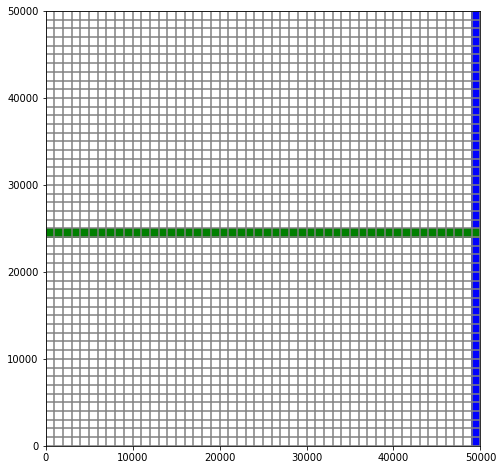

In [126]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mapview = flopy.plot.PlotMapView(model=m3)
ibound = mapview.plot_ibound()
wel = mapview.plot_bc("WEL")
riv = mapview.plot_bc("RIV")
linecollection = mapview.plot_grid()

### Cross section of the layered model
For more examples of cross section plotting check out this notebook: https://github.com/modflowpy/flopy/blob/develop/examples/Notebooks/flopy3.3_PlotCrossSection.ipynb 

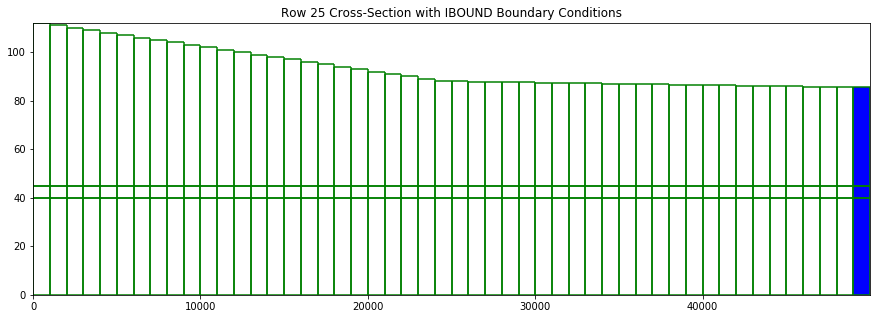

In [127]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m3, line={'row': 13}) #note use the key 'column' if you want to plot a column instaed
patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='green')
t = ax.set_title('Row 25 Cross-Section with IBOUND Boundary Conditions')

# 5. Add particles to both scenarios


#### Run the 1 layer scenario

In [128]:
moddirmp="/Applications/MODFLOW/mp7"

locsb = [[0, z2_rowur, z2_colll, 0, z2_rowll, z2_colur]]
sd= flopy.modpath.CellDataType(drape=0, columncelldivisions=3, rowcelldivisions=3, layercelldivisions=1)
p= flopy.modpath.LRCParticleData(subdivisiondata=[sd], lrcregions=[locsb])
pg1 = flopy.modpath.ParticleGroupLRCTemplate(particlegroupname='PG1',particledata=p,filename='ex01a.pg1.sloc')
particlegroups = [pg1]

defaultiface = {'RECHARGE': 6, 'ET': 6}

#### Run the 3 layer scenario

In [129]:
locsb = [[0, z2_rowur, z2_colll, 0, z2_rowll, z2_colur]]
sd= flopy.modpath.CellDataType(drape=0, columncelldivisions=1, rowcelldivisions=1, layercelldivisions=1)
p= flopy.modpath.LRCParticleData(subdivisiondata=[sd], lrcregions=[locsb])
pg1 = flopy.modpath.ParticleGroupLRCTemplate(particlegroupname='PG1',particledata=p,filename='ex01a.pg1.sloc')
particlegroups = [pg1]

defaultiface = {'RECHARGE': 6, 'ET': 6}

mpname3=os.path.join(modelname3 + '_mp')
print(mpname3)
mp3 = flopy.modpath.Modpath7(modelname=modelname3 + '_mp', flowmodel=m3, exe_name=moddirmp)
mpbas = flopy.modpath.Modpath7Bas(mp3, porosity=n, defaultiface=defaultiface)
mpsim = flopy.modpath.Modpath7Sim(mp3, simulationtype='combined',
                                  trackingdirection='backward',
                                  weaksinkoption='stop_at',
                                  weaksourceoption='stop_at',
                                  budgetoutputoption='summary',
                                  stoptimeoption='extend', 
                                  particlegroups= particlegroups)


mp3.add_package(rch)
mp3.add_package(evt)
mp3.write_input()
mp3.run_model()
mp3.get_package_list()

BaseModel_mp
FloPy is using the following  executable to run the model: /Applications/MODFLOW/mp7

MODPATH Version 7.2.001   
Program compiled Jan 27 2020 10:33:17 with GFORTRAN compiler (ver. 8.2.0)       


Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
         0 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
       408 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.                                                        


['MPBAS', 'MPSIM', 'RCH', 'EVT']

# 6. Read in the outputs

###  Modflow outputs - Heads and budget files

In [130]:
# Head - 1 layer model 
#headobj1 = bf.HeadFile(modelname1+'.hds')    #reads the binary head file
#times = headobj1.get_times()                #returns a list of timesteps
#head1 = headobj1.get_data(totim=times[-1])        #returns a numpy array of heads for specified time (last timestep)

#Head - 3 layer model 
headobj3 = bf.HeadFile(modelname3+'.hds')    #reads the binary head file
times = headobj3.get_times()                #returns a list of timesteps
head3 = headobj3.get_data(totim=times[-1])        #returns a numpy array of heads for specified time (last timestep)


#Water balance - 1 layer
#budgobj1 = bf.CellBudgetFile(modelname1+'.cbc')   #reads the cell budget file    
#print(budgobj1.get_unique_record_names())
#kstpkper_list1 = budgobj1.get_kstpkper()          #returns a list of stress periods & timesteps
#frf1 = budgobj1.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
#fff1 = budgobj1.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 
#et1 = budgobj1.get_data(text='ET', totim=1.0)
#recharge1 = budgobj1.get_data(text='RECHARGE', totim=1.0) 



#Water balance - 3 layer
budgobj3 = bf.CellBudgetFile(modelname3+'.cbc')   #reads the cell budget file    
print(budgobj3.get_unique_record_names())
kstpkper_list3 = budgobj3.get_kstpkper()          #returns a list of stress periods & timesteps
frf3 = budgobj3.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fff3 = budgobj3.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 
et3 = budgobj3.get_data(text='ET', totim=1.0)
recharge3 = budgobj3.get_data(text='RECHARGE', totim=1.0) 
print(len(frf3))




[b'   CONSTANT HEAD', b'FLOW RIGHT FACE ', b'FLOW FRONT FACE ', b'FLOW LOWER FACE ', b'   RIVER LEAKAGE', b'              ET', b'        RECHARGE']
1


### Particle outputs 

In [131]:
### 1 layer model 
#Particle pathlines
#fpth1 = os.path.join(mpname1 + '.mppth')
#print(fpth1)
#p1 = flopy.utils.PathlineFile(fpth1)

#Particle endpoints
#fpth1 = os.path.join(mpname1 + '.mpend')
#e1 = flopy.utils.EndpointFile(fpth1, verbose=False)

#make a subset which is all the particles
#pall1 = p1.get_alldata()  
#eall1 = e1.get_alldata()
        
#make a subset which is particles ending in the well
#nodewell = m1.dis.get_node([(0,well_row, well_col)])
#print(nodewell)
#pwell1 = p1.get_destination_pathline_data(dest_cells=nodewell)
#ewell1 = e1.get_destination_endpoint_data(dest_cells=nodewell)


### 3 layer model 
#Particle pathlines
fpth3 = os.path.join(mpname3 + '.mppth')
p3 = flopy.utils.PathlineFile(fpth3)

#Particle endpoints
fpth3 = os.path.join(mpname3 + '.mpend')
e3 = flopy.utils.EndpointFile(fpth3, verbose=False)

#make a subset which is all the particles
pall3 = p3.get_alldata()  
#eall3 = e3.get_alldata()
        
#make a subset which is particles ending in the well
nodewell3 = m3.dis.get_node([(2,well_row, well_col)])
print(nodewell3)
pwell3 = p3.get_destination_pathline_data(dest_cells=nodewell3)
ewell3 = e3.get_destination_endpoint_data(dest_cells=nodewell3)

#elocs = []
#enodes = []
#for idx in range(int(z2_rowur), int(z2_rowll)):
 #   for idy in range(int(z2_colll), int(z2_colur)):
        #elocs.append((0, idx, idy))
  #      enodes.append(m1.dis.get_node([(0,idx,idy)]))
#prezone1 = p3.get_destination_pathline_data(dest_cells=enodes)
#erezone1 = e3.get_destination_endpoint_data(dest_cells=enodes)         
#print(enodes)


[6437]


# 6. Plotting
#### Cross section plots

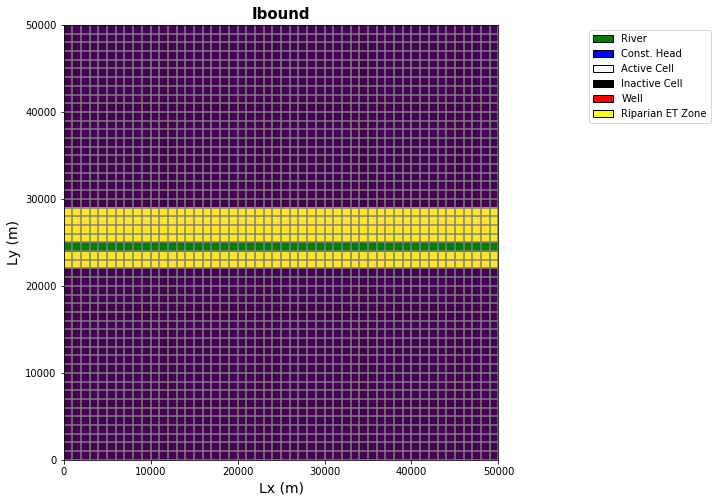

In [132]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

modelmap = flopy.plot.PlotMapView(model=m3)
quadmesh = modelmap.plot_ibound()
quadmesh = modelmap.plot_array(ET_zones)
quadmesh = modelmap.plot_bc('WEL')
quadmesh = mapview.plot_array(ET3_zones)
riv_plot = modelmap.plot_bc(ftype='RIV')
quadmesh = mapview.plot_array(R_zones)
grid = modelmap.plot_grid()


#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='green',label='River',ec='black'),
                    mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black'),
                    mp.patches.Patch(color='red',label='Well',ec='black'), 
                   mp.patches.Patch(color='yellow',label='Riparian ET Zone',ec='black')],
                   bbox_to_anchor=(1.5,1.0))

plt.show(modelmap)

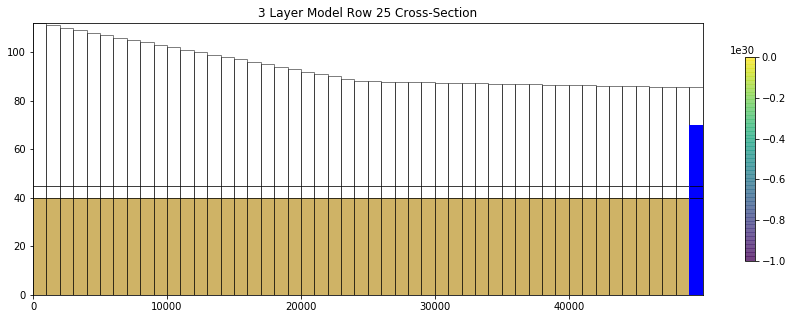

In [135]:
#### 3 layered model 
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m3, line={'row': 13}) #note use the key 'column' if you want to plot a column instaed
pc = xsect.plot_array(head3, masked_values=[999.], head=head3, alpha=0.5)
patches = xsect.plot_ibound(head=head3)
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('3 Layer Model Row 25 Cross-Section')
cb = plt.colorbar(pc, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect.plot_surface(head3[0,:,:], masked_values=[999.], color='blue', lw=1)


### Plot particle pathlines

###  1 Layer Head Contours

### 3 Layer head contours

In [76]:
print("ET Scenario")
print("Total Reacharge", np.sum(recharge3[0][1]))
print("Total ET", np.sum(et3[0][1])) 


ET Scenario
Total Reacharge 30000.0
Total ET -6929.9526
